# Word2Vec

The code for this lecture is based off the great tutorial example from tensorflow!

Walkthrough:

https://www.tensorflow.org/tutorials/word2vec

Raw Code: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

# Step 0: Imports

In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

# Step 1: The data.

In [2]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [4]:
# Use Defaults (this make take awhile!!)
words = fetch_words_data()

In [5]:
# Total words
len(words)

17005207

In [6]:
# Random slice of words
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [7]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

## Build Word Counts

In [8]:
from collections import Counter

In [9]:
mylist = ["one",'one','two']

In [10]:
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [11]:
Counter(mylist).most_common(1)

[('one', 2)]

## Create Word Data and Vocab

In [12]:
def create_counts(vocab_size=50000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [13]:
vocab_size = 50000

In [14]:
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)

In [15]:
data[0]

5233

In [16]:
(words[100],data[100])

('interpretations', 4193)

In [17]:
vocabulary.shape

(50000,)

In [18]:
vocabulary[np.random.randint(0,50000)]

'monochromatic'

## Function for Batches

Direct from the word2vec file from TensorFlow Docs

In [19]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [20]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [21]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080])

In [22]:
labels

array([[  11],
       [5233],
       [5233],
       [  11],
       [5233],
       [  11],
       [5233],
       [  11]])

## Constants

In [23]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector / Dimension del vector de incrustacion
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2        

In [24]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [25]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [26]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [27]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [28]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [29]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

### Optimizer

In [30]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [31]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [32]:
data_index = 0

In [33]:
# Add variable initializer.
init = tf.global_variables_initializer()

# Session

In [34]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [35]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 20001

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  317.513916015625
Average loss at step  1000 :  10523.992076263428
Average loss at step  2000 :  23587.546261131287
Average loss at step  3000 :  27202.05499020195
Average loss at step  4000 :  31982.15850098029
Average loss at step  5000 :  35531.65334378052
Average loss at step  6000 :  36673.2262302866
Average loss at step  7000 :  38822.069555892944
Average loss at step  8000 :  42189.502932148454
Average loss at step  9000 :  45173.47159280396
Average loss at step  10000 :  43994.826839312074
Average loss at step  11000 :  43430.858962433434
Average loss at step  12000 :  50622.08667335129
Average loss at step  13000 :  48414.12603804684
Average loss at step  14000 :  41242.95138149408
Average loss at step  15000 :  44059.065038482666
Average loss at step  16000 :  46115.4151523684
Average loss at step  17000 :  42036.42795513892
Average loss at step  18000 :  43281.01904251098
Average loss at step  19000 :  42924.732488449095
Average loss at step  20000 

# Visualizing Results

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [89]:
type(final_embeddings)

numpy.ndarray

In [90]:
final_embeddings.shape

(50000, 150)

In [91]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [ ]:
plot_only = 5000
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [ ]:
labels = [vocabulary[i] for i in range(plot_only)]

In [ ]:
low_dim_embed.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18,18)) #in inches
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,
                    xy=(x,y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    

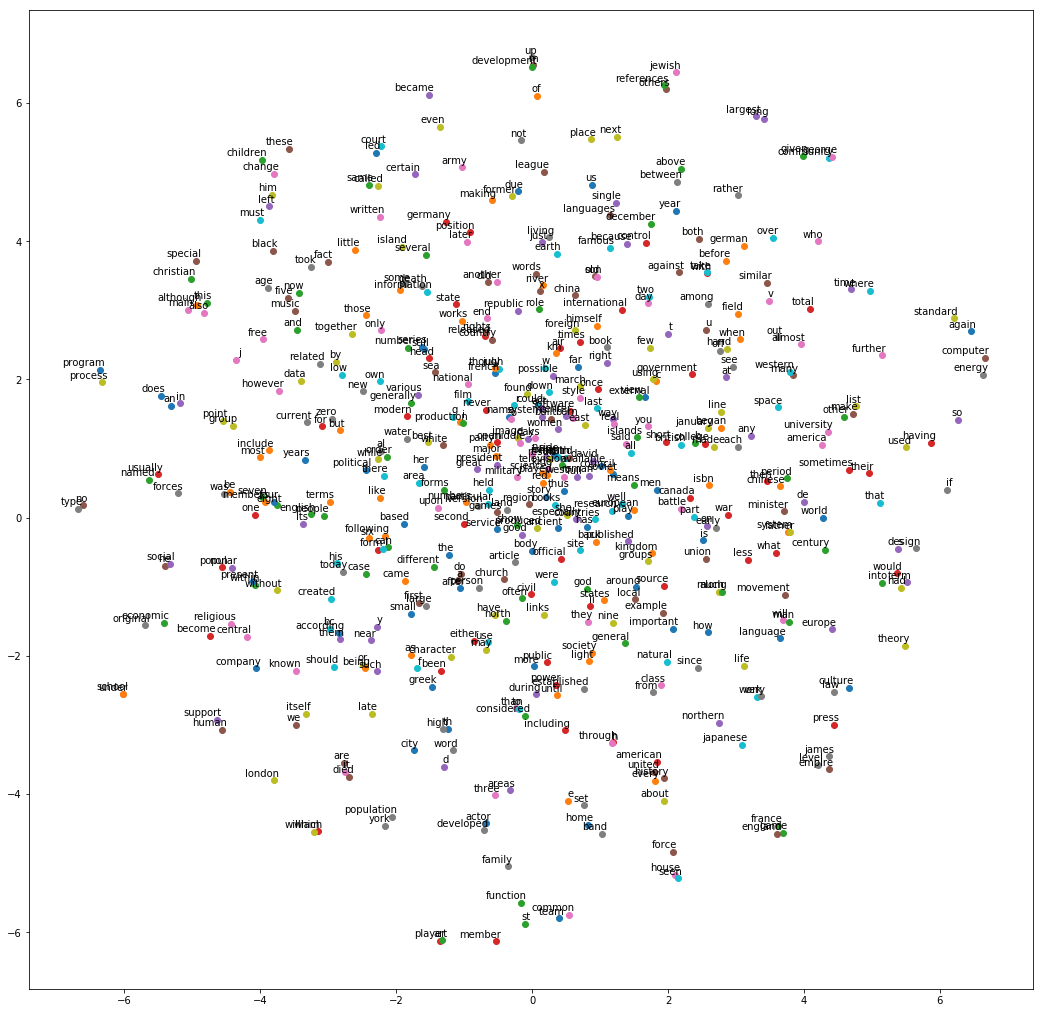

In [77]:
plot_with_labels(low_dim_embed, labels)

## Also check out gensim!

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [ ]:
final_embeddings = np.load("trained_embeddings_200k_steps.npy")

In [ ]:
final_embeddings.shape

# Great Job!

In [ ]:
np.save('trained_embeddings_200k_steps',final_embeddings)